# Problem Set 2, due FRIDAY, MAY 22, 2020 @ 11:59pm

This problem set covers logistic regression, cross validation, and kernels.

*Please*:
1. Complete the information below with your name, e-mail address, and student ID number
2. Complete the assignment carefully, working through all parts (question 1, question 2, question 3a, and question 3b)
3. Before submitting, select "Restart Kernel and Run All Cells..." from the "Kernel" menu, to make sure this notebook runs cleanly.
4. Submit using the "submitps" command

<b>Your information</b>:<br>
Name: Hyuna Kwon  <br>
e-mail address: hkwon019@ucr.edu <br>
SID #: 862063261<br>

By submitting this notebook, you are asserting that the work presented is your own, was completed without external aid, and was completed for this offering of this course.

You may *not* use any additional libraries for this problem set.  Do not add "import" lines.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import time

trainX = np.loadtxt('spamtrainX.data')
trainY = np.loadtxt('spamtrainY.data')[:,np.newaxis]
testX = np.loadtxt('spamtestX.data')
testY = np.loadtxt('spamtestY.data')[:,np.newaxis]
trainXextra = (trainX>0).astype(float)
testXextra = (testX>0).astype(float)

# again, we will "z-normalize" the features:
# we'll also add some binary features.  The features from the "raw data" are the counts of the number of words
# however, what is also useful is just whether a word is present (1) or not (0), which ignores the number
# of times it is present.  So, we'll tack on those features as an extra set (doubling n: the number of features)
mux = np.mean(trainX,axis=0)
stdx = np.std(trainX,axis=0)
trainX = (trainX-mux)/stdx
trainX = np.hstack((trainX,trainXextra))
testX = (testX-mux)/stdx
testX = np.hstack((testX,testXextra))

## Overview:

This assignment consists of a few parts:
1. You will use a provided gradient descent optimizer to build a logistic regression learning algorithm
2. You will derive a kernelized version of logistic regression and implement it
3. You will use cross-validation to compare these different methods on the spam data set

The spam dataset is a binary classification problem.
Y is encoded as +1/-1.  X is encoded as a vector of features, like relative frequency of different words, character, and the like.  You can read more at http://archive.ics.uci.edu/ml/datasets/Spambase

[ a general note: you may get overflow errors on np.exp.  This is not necessarily a problem, as it often just means that the stepsize on GD was too large, but the GD code will automatically reduce it and things should carry on as normal.]

## Question 1 (2 points)

***
Below is a general-purpose GD optimizer.  It takes as input a starting point, a function to be optimized and a function that is the gradient of the function to be optimized.  It returns a (local) minimum point of the function.

The example just below it shows how to use it for non-machine-learning optmization problem.  Read the code to understand what is going on.

In [2]:
# provided code for grad desc. 
# eta is starting value for eta (no need to adjust) 
# ittfn is optional function to call on each iteration (no need to use, except if you wish for debugging)
def graddesc(x0,fn,gradfn,eta = 0.1, ittfn=None):
    x = x0
    oldf = fn(x)
    df = 1
    mineta = 1e-16
    while(df>1e-6):
        g = gradfn(x)
        #print(x)
        #print(eta)
        while eta>mineta:
            newx = x - eta*g
            newf = fn(newx)
            if oldf>newf+abs(newf)*0.001+1e-6:
                break
            eta *= 0.5
        if ittfn is not None:
            ittfn(x,eta,newf)
        if eta<=mineta:
            break
        oldf = newf
        x = newx
    return x

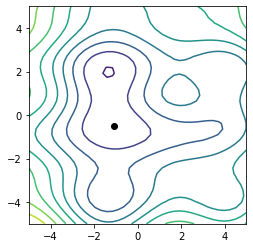

In [3]:
# here is an example of using the optimization routine above
# (you don't need to do anything here, just example code of how graddesc, above, could be used)
# try moving the stating point (x0) around to see the effects, if you are curious

def myf(x): # a simple 2d function
    return 0.25*np.sum(x*x,0) + 2*np.sin(x[0,:]) + np.sin(2*x[1,:]) + np.sin(x[0,:])*np.sin(x[1,:])

def mygrad(x):
    a = x[0,0]
    b = x[1,0]
    return np.array([[0.5*a + 2*np.cos(a) + np.cos(a)*np.sin(b),
                      0.5*b + 2*np.cos(2*b) + np.sin(a)*np.cos(b)]]).T

def displayprogress(w,eta,fval):
    display.clear_output(wait=True)
    print(w,eta,fval)

xs1 = np.linspace(-5,5,40)
ys1 = np.linspace(-5,5,40)
xs,ys = np.meshgrid(xs1,ys1)
pts = np.hstack((xs.reshape((1600,1)),ys.reshape((1600,1))))
vals = myf(pts.T).T
plt.contour(xs,ys,vals.reshape((40,40)),10)
plt.axis('square')

x0 = np.array([[0.0,0.0]]).T
#x0 = np.array([[-4.0,-4.0]]).T
xmin = graddesc(x0,myf,mygrad) #,0.1,displayprogress)
_ = plt.plot(xmin[0,0],xmin[1,0],'ko')

<font color="red">**TO DO:**  Complete the code below to provide a function that will learn and test a (linear) logistic regression classifier with L2-regularization</font>

Specifics:
1. Regularize all weights, even any that might be the "intercept," to make this simpler.
2. Start GD at the ridge regression solution (pretending that the y values are for a regression problem).  This is a good starting spot.
3. If the result, f(x), is exactly zero, that is an error, for y=+1 and for y=-1.

In [4]:
## TO COMPLETE
# feel free to add extra functions

# X is m-by-n, Y is m-by-1, lam is a scalar (lambda of a regularization term lambda/2 * w^T * w)
# returns a n-by-1 vector of weights
        
    
def cost(X,Y,lam):
    w = np.linalg.solve(X.T@X + lam*np.identity(X.shape[1]),X.T@Y)
    return w

def llr(s):
    return 1/(1+np.exp(-s))

def loss_function(X,Y,lam,w):
    p = 1/(1+np.exp(-Y*X@w))
    Llog = np.sum(-np.log(p)) + lam*w.T@w/2
    reg = lam*w.T@w/2
    L = Llog + reg
    return L

def grad(X,Y,lam,w):
    p = 1/(1+np.exp(-Y*X@w))
    t = (1-p)*Y
    gradLog = -X.T@t
    reg = lam*w
    gradient = gradLog + reg
    return gradient
    
    
def learnlr(X, Y, lam):
    w0 = np.ones((X.shape[1],1))
    fn = lambda w: loss_function(X,Y,lam,w)
    gradfn = lambda w: grad(X,Y,lam,w)
    w = graddesc(w0,fn,gradfn)
    return w

# X is m-by-n, Y is m-by-1, w is n-by-1
# returns the average 0-1 error on the input data set.  That is, it returns the fraction of examples misclassified
def testlr(X,Y,w):
    probs = X@w
    predictions = np.where(probs >= 0, 1, -1)
    #error = np.mean(np.abs(predictions-testY))/2
    error = np.sum(predictions*Y <= 0)/Y.shape[0]
    print(error)
    return error


Below is a bit of code that runs the above for a particular value of lambda=100 (somewhat randomly chosen) and reports the testing error on the dataset.  You should get **0.0737** (or about) as the result.

In [5]:
# add "intercept term:"
trainXand1 = np.hstack((np.ones((trainX.shape[0],1)),trainX))
testXand1 = np.hstack((np.ones((testX.shape[0],1)),testX))
#print(learnlr(trainXand1, trainY,100))

# train and test
testlr(testXand1,testY,learnlr(trainXand1,trainY,100))

0.07183010618363522


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


0.07183010618363522

## Question 2 (8 points)
***

Now we will derive the kernel version of logistic regression.

### part (a) (2 points)

We will be optimizing
\begin{align*}
L(f) &= \sum_{i=1}^m l_{\text{lr}}(y_i,f(x_i)) + \frac{\lambda}{2}\|f\|_{{\cal H}_K}^2
\end{align*}
where $l_{\text{lr}}$ is the logistic regression loss from class and the last term is the norm of the function in the reproducing kernel Hilbert space with kernel $K$.

From the Representer Theorem, we know that $f$ must have the following form
\begin{align*}
f(x) &= \sum_{j=1}^m \alpha_j K(x_j,x)
\end{align*}

Thus, our parameters are the $\alpha$s, one for each training point.  Learning is the process of picking the parameters to minimize the total loss ($L$).  To this end, write down the loss function in terms of $\alpha$ (the vector of all of the $\alpha_j$ values).

Note, $\|f\|_{{\cal H}_K}^2 = \alpha^\top K\alpha$.  Let $K$ be a matrix for which $K_{ij} = K(x_i,x_j)$.  You may also wish to let $K_i$ be the $i$th column of the matrix $K$.

<font color=red>__To Do: Place your derivation of $L$ in terms of $\alpha$ below__</font>

\begin{align*}
f(x_i) &= \sum_{j=1}^m \alpha_j K(x_j,x_i) \\
&= \sum_{j=1}^m \alpha_j K_{ji} \\
&= \alpha^\top K^{(i)} \\
L(f) &= \sum_{i=1}^m l_{\text{lr}}(y_i,f(x_i)) + \frac{\lambda}{2}\|f\|_{{\cal H}_K}^2 \\
l_{\text{lr}}(y_i,f(x_i)) &= {\text{log}}(1+{\text{exp}}[-y_if(x_i)])\\
 &= {\text{log}}(1+{\text{exp}}[-y_i\alpha^\top K^{(i)}]) \\
L(f) &= \sum_{i=1}^m{\text{log}}(1+{\text{exp}}[-y_i\alpha^\top K^{(i)}]) + \frac{\lambda}{2}\alpha^T K \alpha
\end{align*}

### Part b (2 points)

To optimize this loss, we will just use gradient descent. (We could use Newton-Raphson, just like "normal" logistic regression, but for this assignment, we will keep it simpler by not needing the Hessian.)  To that end, derive the gradient of $L$ with respect to $\alpha$ below.

<font color=red>__To Do: Place your derivation of $\nabla_\alpha L$ below__</font>

\begin{align*}
L(f) &= {\text{log}}(1+{\text{exp}}[-y_i\alpha^\top K^{(i)}]) + \frac{\lambda}{2}\alpha^T K \alpha \\
\nabla_\alpha L &= \sum_{i=1}^m \frac{y_i {\text{exp}} (-y_i \alpha^\top K^{(i)})}{1 + {\text{exp}}(-y_i \alpha^\top K^{(i)})}K_i^\top + \lambda \alpha^\top K
\end{align*}

## Part d (2 points)

<font color="red">Below, write code to calculate the loss function and its gradient (as you derived above).</font>  I would recommend writing them in terms of the matrix $K$ (as opposed to the kernel function $K(\cdot,\cdot)$), because you don't want to reevaluate the kernel function on all of the training points each time you evaluate the loss function or its gradient.

In [6]:
### !!! Your code here !!!!

# alpha is what is to be optimized (an m-by-1 vector)
# K is the kernel matrix (an m-by-m matrix) 
# Y are the targets (an m-by-1 matrix of +1/-1)
# lam is the value of lambda
# returns the value of the loss function
def kernellrloss(alpha,K,Y,lam):
    L = np.sum(np.log(1+np.exp(-Y.T*alpha.T@K))) + lam*alpha.T@K@alpha/2
    return L

# same as above, but returns the gradient of the loss function wrt alpha
def kernellrgrad(alpha,K,Y,lam):
    first_term = -np.tile((np.exp(-Y.T*alpha.T@K))/(1+np.exp(-Y.T*alpha.T@K))*Y.T,(Y.shape[0],1))*K
    second_term = lam*alpha.T@K
    gradient = first_term.sum(axis=1).T + second_term
    return gradient.T

## Part e (2 points)

<font color="red">Use the gradient descent function from part a and the loss and gradient functions from above to implement the learning function below.  Also implement the testing function.</font>

For this case, start alpha at all 0s for the GD optimization.

In [13]:
### !!! Your code here !!!

# takes as input X (m-by-n) and Y (m-by-1) and a kernelfn that will take X and return an m-by-m matrix
# returns learned alpha values
def learnkernellr(X,Y,kernelfn,lam):
    alpha0 = np.zeros((Y.shape[0],1))
    loss_fn = lambda alpha: kernellrloss(alpha,kernelfn(X,X),Y,lam)
    grad = lambda alpha: kernellrgrad(alpha,kernelfn(X,X),Y,lam)
    
    minimum = graddesc(alpha0,loss_fn,grad)
    return minimum
    
# takes as input X (m'-by-n) and Y (m'-by-1) and the original training X (m-by-1), a kernel function, and the learned alpha values
# returns the average number of errors on the (testing) X and Y
def testkernellr(X,Y,trainX,kernelfn,alpha):
    probs = (alpha.T@kernelfn(trainX,X)).T
    predictions = np.where(probs >= 0, 1, -1)
    #error = np.mean(np.abs(predictions-testY))/2
    error = np.sum(predictions*Y <= 0)/Y.shape[0]
    print(error)
    return error


The code below will test your results using a squared-exponential kernel with sigma = 0.3.  You should get testing error rate of 0.08807 (or about).

In [8]:
def sqexpkernel(x1,x2,sigma):
    def up(x):
        return x if len(x.shape)!=1 else x[np.newaxis,:]
    x1 = up(x1)
    x2 = up(x2)
    d = x1[:,np.newaxis,:] - x2[np.newaxis,:,:]
    return np.exp(-np.sum(d*d,2)/(2*sigma*sigma))

sqexp03 = lambda X1,X2 : sqexpkernel(X1,X2,0.3)
print (testkernellr(testX,testY,trainX,sqexp03,learnkernellr(trainX,trainY,sqexp03,100)))

0.0868207370393504


## Question 3 (5 points)
***

Now we will use n-fold cross validation (with n=3) to find the hyper-parameters that work best.

We will try both the linear logistic regression (from question 1) and the kernel logistic regression (from question 2).

### Part a (2 points)

Let's start with linear logistic regression.  We only have a single hyper-parameter: lambda.  

So plot (on a semilogx plot) the 3-fold cross validation error as a function of lambda.  Vary lambda from 0.0001 to 10 to get a good range.

The code below performs n-fold cross validation.

[If you are not familiar with using lambda functions or similar to Curry arguments and so using xvalideval is confusing, feel free to write your own cross-validation using this as a template.]

<font color="red">Complete the code block below to make the plot.</font>

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


0.065
0.074
0.066
0.065
0.074
0.066
0.065
0.074
0.066
0.065
0.074
0.066
0.065
0.074
0.066
0.065
0.074
0.066
0.065
0.074
0.066
0.065
0.074
0.066
0.065
0.074
0.066
0.065
0.074
0.066
0.065
0.074
0.066
0.065
0.074
0.066
0.065
0.074
0.066
0.065
0.074
0.066
0.065
0.074
0.066
0.065
0.074
0.066
0.065
0.074
0.066
0.065
0.074
0.066
0.065
0.074
0.066
0.065
0.074
0.066
0.065
0.074
0.066
0.065
0.074
0.066
0.065
0.074
0.066
0.065
0.074
0.066
0.065
0.074
0.066
0.065
0.074
0.065
0.065
0.074
0.065
0.065
0.074
0.065
0.065
0.074
0.065
0.065
0.074
0.065
0.065
0.074
0.065
0.065
0.074
0.065
0.065
0.074
0.065
0.065
0.074
0.065
0.065
0.074
0.065
0.065
0.074
0.065
0.065
0.074
0.065
0.065
0.074
0.065
0.065
0.074
0.065
0.065
0.074
0.065
0.065
0.074
0.065
0.065
0.074
0.065
0.065
0.074
0.065
0.065
0.074
0.065
0.065
0.074
0.065
0.065
0.074
0.065
0.065
0.074
0.065
0.065
0.074
0.065
0.065
0.074
0.065
0.065
0.074
0.065
0.065
0.074
0.065
0.065
0.074
0.065
0.065
0.074
0.065
0.065
0.074
0.065
0.065
0.074
0.065
0.065
0.07

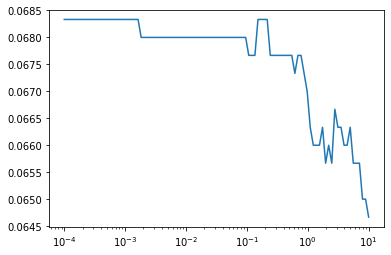

In [9]:
## !!! Your code for cross-validation and plotting here !!!

# X and Y are the training data
# evalfn is a function of the form evalfn(trainX,trainY,validX,validY)
# which should report the error rate on the validX,validY set
# when the method is trained on the trainX,trainY set
def xvalideval(X,Y,evalfn):
    nfold = 3
        
    m = X.shape[0]
    splits = np.linspace(0,m,nfold+1).astype(int)
    v = 0
    for low,high in zip(splits[0:-1],splits[1:]):
        trainX = np.vstack((X[:low,:],X[high:,:]))
        trainY = np.vstack((Y[:low,:],Y[high:,:]))
        validX = X[low:high,:]
        validY = Y[low:high,:]
        v +=evalfn(trainX,trainY,validX,validY)
    return v/nfold

lambdas = np.logspace(-4,1,100)

def myevalfn(trainX,trainY,validX,validY,lam):
    trainXand1 = np.hstack((np.ones((trainX.shape[0],1)),trainX))
    validXand1 = np.hstack((np.ones((validX.shape[0],1)),validX))
    error = testlr(validXand1,validY,learnlr(trainXand1,trainY,lam))
    return  error

def error_fn(lam):
    evalfn = lambda trainX,trainY,validX,validY: myevalfn(trainX,trainY,validX,validY,lam)
    error = xvalideval(trainX,trainY,evalfn)
    return error
    
error_array = [error_fn(lam) for lam in lambdas]

plt.semilogx(lambdas,error_array)
plt.show()
# YOUR CODE HERE
#CVE = sum(xvalideval(X,Y,evalfn))/3

### Part b (2 points)

We'll now tackle kernelized logistic regression.  We have to pick the kernel.  For this problem set, we'll use the squared-exponential kernel from above (although I encourage you to try some others!).  We then have two hyper-parameters: lambda (the regularization strength) and sigma (the width of the kernel).  In general, we would try combinations of both.  However, I have already done so, and the choice of lambda has very little effect.  So, just fix it at 1.  Instead, vary sigma (from 0.01 to 100) and plot the 3-fold cross-validation error as a function of sigma (again, on a semilogx plot).

Note: this plot could take a bit longer

<font color="red">Complete the code block below to generate this plot.</font>

In [14]:
# Your code here

sigmas = np.logspace(-2,2,10)


def error_fn_kernel(s):
    print(s)
    sqexp = lambda X1,X2 : sqexpkernel(X1,X2,s)
    evalfn = lambda trainX,trainY,validX,validY: testkernellr(validX,validY,trainX,sqexp,learnkernellr(trainX,trainY,sqexp,1))
    return xvalideval(trainX,trainY,evalfn)

error_array_kernel = [error_fn_kernel(s) for s in sigmas]

plt.semilogx(sigmas,error_array_kernel)
plt.show()

0.01


KeyboardInterrupt: 

### part c (1 points)

Which combination (method and hyper-parameter) is best?  What is the testing error for this combination?

<font color="red">Place code and answer below</font>

In [15]:
# your answer here

# It is clearly seen from the plots above that logistic regression with L2 regularizaion has smaller error than squared-exponential Kernel logistic regression with L2.
# The lambda value for the smallest error is calculated as follows
minimum = min(error_array)
print(minimum)
minimum_lambda = lambdas[error_array == minimum]
print(minimum_lambda)

0.06466666666666666
[10.]
